# Drum Generation Transformer

In this tutorial, we will learn how to train a small auto-regressive transformer model for simplified drum beat generation in MIDI.

At the end of this tutorial, we will be able to create a drum beat of a bar's length and investigate some useful techniques for encoding MIDI as input to a transformer.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    ! apt install fluidsynth
    # Issues on Colab with newer versions of MIDO
    # this install should be removed after the following
    # pull request is accepted in MIDO
    # https://github.com/mido/mido/pull/584
    ! pip install mido==1.2.10
    ! pip install pyfluidsynth
    ! pip install partitura
    ! git clone https://github.com/cpjku/partitura_tutorial
    import sys
    sys.path.insert(0, "./partitura_tutorial/notebooks/04_generation/")

### Imports

Import the required packages.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import time
import glob
import matplotlib.pyplot as plt
import copy
import pickle
import warnings
from typing import List, Optional, Tuple, Union

from scipy.stats import gaussian_kde


import torch
from torch import nn, optim
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import os
if not IN_COLAB:
    os.environ['KMP_DUPLICATE_LIB_OK']='True'
import partitura as pt

warnings.simplefilter("ignore", UserWarning)

### External files

If run locally, external scripts are loaded directly from the cloned tutorial repository.

If run in colab, external scripts are imported by httpimport.

In [3]:
from generation_helpers import (
    INV_PITCH_DICT_SIMPLE,
    tokens_2_notearray,
    save_notearray_2_midifile,
    generate_tokenized_data,
    batch_data,
    PositionalEncoding,
    Transformer,
    sample_from_logits,
    sample_loop,
)

## Data Loading

I this tutorial we will work with the groove midi dataset, which contains MIDI drum grooves from a multitude of genres. For simplicity we load only the MIDI files in 4-4 from the dataset. For loading we use *Partitura*.
If you want to load a precomputed and preprocessed dataset you can skip the next cells until the last cell before section 4 where it is loaded.

In [4]:
if IN_COLAB:
    directory = os.path.join(
        "./partitura_tutorial/notebooks/04_generation", "./groove-v1.0.0-midionly"
    )
else:
    directory = os.path.join(os.getcwd(), "./groove-v1.0.0-midionly")

typ_44 = [
    os.path.basename(f)
    for f in list(glob.glob(directory + "/groove/*/*/*.mid"))
    if "4-4" in f
]

beat_type = [g.split("_")[-2] for g in typ_44]
tempo = [int(g.split("_")[-3]) for g in typ_44]
vals, counts = np.unique(tempo, return_counts=True)
kde_tempo = gaussian_kde(tempo)

### Histogram of tempos marked in file names

Let's take a closer look at the data by plotting the histogram of tempi from the target pieces.

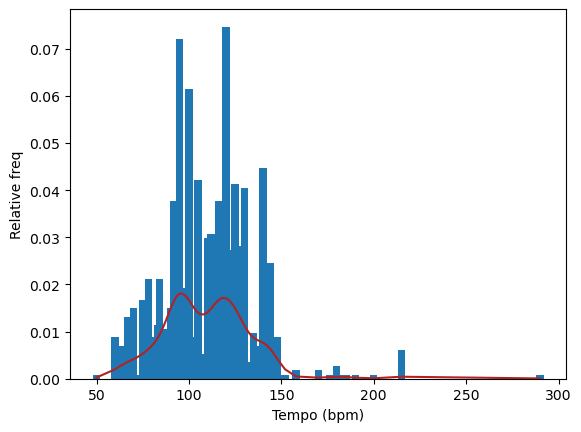

In [5]:
plt.bar(vals, counts/ counts.sum(), width=4, align="center",)
plt.plot(vals, kde_tempo(vals), c="firebrick")
plt.xlabel("Tempo (bpm)")
plt.ylabel("Relative freq")
plt.show()

We can almost notice a bi-modal distribution curve with a mean around a 100 beats per minute. Now let's define the `load_data` function.

In [6]:
def load_data(
    directory: str="./groove-v1.0.0-midionly",
    min_seq_length: int=10,
    time_sig: str="4-4",
    beat_type: Optional[str]=None,
) -> List[np.ndarray]:
    """
    loads groove dataset data from directory
    into a list of dictionaries containing the
    note array as well as note sequence metadata.

    Args:
        directory: dir of the dataset
        min_seq_length: minimal sequence length, a
            all shorter performances are discarded
        time_sig: only performances of this time sig
            are loaded
        beat_type: type of beat to load ("beat",
            "fill", or None = both)

    Returns:
        a list of dicts containing note arrays.

    """
    # load data
    files = glob.glob(directory + "/groove/*/*/*.mid")
    files.sort()
    sequences = []
    if beat_type is None:
        beat_types = ["beat", "fill"]
    else:
        beat_types = [beat_type]
    for fn in files:
        bn = os.path.basename(fn)
        bns = bn.split("_")
        tempo = int(bns[-3])
        bt = bns[-2]
        ts = bns[-1].split(".")[-2]
        if ts == time_sig and bt in beat_types:
            seq = pt.load_performance_midi(fn)[0]
            if len(seq.notes) > min_seq_length:
                na = seq.note_array()
                namax = (na["onset_tick"] + na["duration_tick"]).max()
                namin = (na["onset_tick"]).min()
                dur_in_q = (namax - namin) / seq.ppq
                seq_object = {
                    "id": bn,
                    "na": na,
                    "ppq": seq.ppq,
                    "tempo": tempo,
                    "beat_type": bt,
                    "namax": namax,
                    "namin": namin,
                    "dur_in_q": dur_in_q,
                }
                sequences.append(seq_object)
    return sequences

#### Call the loading function (might take a moment)

In [7]:
seqs = load_data(directory=directory)

### Histogram of performance durations

In this visualization example for the loaded data we plot the histogram of note durations.

In [8]:
dur_in_quarters = [k["dur_in_q"] for k in seqs if k["beat_type"] == "beat"]

470 484


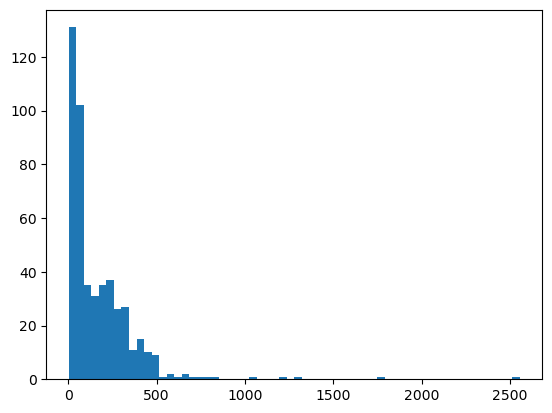

In [9]:
plt.hist(dur_in_quarters, bins=60)
liq = np.array(dur_in_quarters)
print((liq >= 4).sum(), (liq >= -4).sum())

## 3. Data Preprocessing: Segmentation & Tokenization

**Reducing and Encoding the MIDI Sound Profiles**

In this reduces drum generation we encode only 6 main sounds from a list of 22 standard perscussion MIDI sound slots.

Here is a table that shows the Typical Sound to pitch association for drums in MIDI:


 **MIDI PITCH** | **STANDARD ASSOCIATED SOUND** | **REWRITEN SOUND**
----------------|-------------------------------|--------------------
 36             | Kick                          | Kick
 37             | Snare (X-stick)               | Snare
 38             | Snare (Head)                  | Snare
 40             | Snare (Rim)                   | Snare
 43             | Tom 1                         | Tom (Generic)
 45             | Tom 2                         | Tom (Generic)
 48             | Tom 3                         | Tom (Generic)
 47             | Tom 2 (Rim)                   | Tom (Generic)
 50             | Tom 1 (Rim)                   | Tom (Generic)
 48             | Tom 3 (Rim)                   | Tom (Generic)
 48             | Hi-Hat Closed (Bow)           | Hi-Hat
 48             | Hi-Hat Closed (Edge)          | Hi-Hat
 48             | Hi-Hat Open (Bow)             | Hi-Hat
 48             | Hi-Hat Open (Edge)            | Hi-Hat
 49             | Crash 1                       | Crash
 55             | Crash 1                       | Crash
 52             | Crash 2                       | Crash
 57             | Crash 2                       | Crash
 51             | Ride (bow)                    | Ride
 59             | Ride (Edge)                   | Ride
 53             | Ride (Bell)                   | Ride
 Any            | *Default*                     | *Default*

In summary, we associate all the standard MIDI drum sounds to their sound *family*, i.e. Snare-type sounds to a Signle Snare sound, and so on.

**Reducing the MIDI Velocity Encoding**

For MIDI velocity values we encode 8 classes of velocity by applying:

$$ newVel = oldVel / 2^4 $$

We only accept integer values for $newVel$, so we are left with 8 classes of velocity.

**Reducing the Tempo Encoding**

Similarly, we reduce the different tempi found in the training data into 8 classses.

**Beat of Fill Characterization**

We also add information about each measure of the data being a beat or fill/solo part.

**Reducing the Time Encoding**

For the time encoding we use a hierarchical tree division in base 2.
We start by separating the bar in 2, for first and second half note of the 4/4 bar.
We continue for quarter, eight notes, and so on, up to 128 notes. So we use a binary setting for every hierarchical level.

For example the binary hierarchical representation of the second 16th note of the bar would be :



 Half Note    |  Quarter Note   | 8-th Note | 16-th Note    |  32-th Note    | 64-th Note | 128-th Note
 -----------  | ---------       | --------- | ------------- | -------------- | ---------- | -----------
 0   | 0 | 0 | 1 | 0 | 0 | 0


In [10]:
PITCH_DICT_SIMPLE = {
    36: 0,  # Kick
    38: 1,  # Snare (Head)
    40: 1,  # Snare (Rim)
    37: 1,  # Snare X-Stick
    48: 2,  # Tom 1
    50: 2,  # Tom 1 (Rim)
    45: 2,  # Tom 2
    47: 2,  # Tom 2 (Rim)
    43: 2,  # Tom 3
    58: 2,  # Tom 3 (Rim)
    46: 3,  # HH Open (Bow)
    26: 3,  # HH Open (Edge)
    42: 3,  # HH Closed (Bow)
    22: 3,  # HH Closed (Edge)
    44: 3,  # HH Pedal
    49: 4,  # Crash 1
    55: 4,  # Crash 1
    57: 4,  # Crash 2
    52: 4,  # Crash 2
    51: 5,  # Ride (Bow)
    59: 5,  # Ride (Edge)
    53: 5,  # Ride (Bell)
    "default": 6,
}


def pitch_encoder(pitch, pitch_dict=PITCH_DICT_SIMPLE):
    # 22 different instruments  in dataset, default 23rd class
    a = pitch_dict["default"]
    try:
        a = pitch_dict[pitch]
    except:
        print("unknown instrument")
    return a


def time_encoder(time_div, ppq):
    # base 2 encoding of time, starting at half note, ending at 128th
    power_two_classes = list()
    for i in range(7):
        power_two_classes.append(int(time_div // (ppq * (2 ** (1 - i)))))
        time_div = time_div % (ppq * 2 ** (1 - i))
    return power_two_classes


def velocity_encoder(vel):
    # 8 classes of velocity
    return vel // 2**4


def tempo_encoder(tmp):
    # 8 classes of tempo between 60 and 180
    return (np.clip(tmp, 60, 179) - 60) // 15


def tokenizer(seq):
    tokens = list()
    na = seq["na"]
    fill_encoding = 0
    if seq["beat_type"] == "fill":
        fill_encoding = 1
    tempo_encoding = tempo_encoder(seq["tempo"])

    for note in na:
        te = time_encoder(note["onset_tick"] % (seq["ppq"] * 4), seq["ppq"])
        pe = pitch_encoder(note["pitch"])
        ve = velocity_encoder(note["velocity"])

        tokens.append(te + [pe, ve, tempo_encoding, fill_encoding])

    return tokens


def measure_segmentation(seq, beats=4, minimal_notes=1):
    mod = beats * seq["ppq"]
    no_of_measures = int(seq["namax"] // mod + 1)

    segmented_seq = list()
    for measure_idx in range(no_of_measures):
        na = seq["na"]
        new_na = np.copy(na[na["onset_tick"] // mod == measure_idx])
        if len(new_na) >= minimal_notes:
            new_seq = copy.copy(seq)
            new_seq["na"] = new_na
            segmented_seq.append(new_seq)
        else:
            continue
    return segmented_seq

In [11]:
# try uncommenting the next lines to see the outputs of these functions.
# t = tokenizer(seqs[0])
# ss = measure_segmentation(seqs[0], minimal_notes=18)

In [12]:
# print("First Tokenized Note of First sequence : {}".format(t[0]))

### Training set generation (might take a moment)

In [13]:
if not os.path.exists('dataset129.pyc'):

    train_data = generate_tokenized_data(
        seqs,
        measure_segmentation,
        tokenizer,
        minimal_notes=20,
    )
    train_dataloader = batch_data(
        data=train_data,
        batch_size=128,
    )
    with open('dataset129.pyc', 'wb') as fh:
        pickle.dump(train_dataloader, fh)

else:
    with open('dataset129.pyc', 'rb') as fh:
        train_dataloader = pickle.load(fh)

In [14]:
## try uncommenting the next lines to see the outputs of these functions.
# train_dataloader[0].shape # batch, max sequence length, num_tokens

## 4. Model 

![MODEL](https://raw.githubusercontent.com/CPJKU/partitura_tutorial/mlflow/static/drumtransformer.gif)

The embedding input and output dimension of our model uses the reduced representations that were described above.
First, we input with the 7 levels binary hierarchical timing representation in one hot, next instrument (6 classes), velocity (6 classes), tempo (6 classes), and a binary beat as one hot. For the output, every one of those levels also contain a *START* or *END* token. Therefore, the binary one-hot representations go from 2 dimensional vectors to 4 dimensional where the third position is for the *START* token and the fourth position is for the *END* token.

For consistency we repeated the same dimensions for the input Embeddings of the model. Of course this encodings are up to personal interpretation

In [15]:
class MultiEmbedding(nn.Module):
    """A Multiembedding"""

    # Initialization
    def __init__(self, tokens2dims: np.ndarray) -> None:
        super().__init__()
        # self.em_time0 = nn.Embedding(num_tokens, dim_model)
        self.em_time0 = nn.Embedding(tokens2dims[0][0], tokens2dims[0][1])
        self.em_time1 = nn.Embedding(tokens2dims[1][0], tokens2dims[1][1])
        self.em_time2 = nn.Embedding(tokens2dims[2][0], tokens2dims[2][1])
        self.em_time3 = nn.Embedding(tokens2dims[3][0], tokens2dims[3][1])
        self.em_time4 = nn.Embedding(tokens2dims[4][0], tokens2dims[4][1])
        self.em_time5 = nn.Embedding(tokens2dims[5][0], tokens2dims[5][1])
        self.em_time6 = nn.Embedding(tokens2dims[6][0], tokens2dims[6][1])
        self.em_pitch = nn.Embedding(tokens2dims[7][0], tokens2dims[7][1])
        self.em_velocity = nn.Embedding(tokens2dims[8][0], tokens2dims[8][1])
        self.em_tempo = nn.Embedding(tokens2dims[9][0], tokens2dims[9][1])
        self.em_beat = nn.Embedding(tokens2dims[10][0], tokens2dims[10][1])
        # self.total_dim = np.array([[2,2,2,2,2,2,2, # time encoding
        #                  2,2,2,2]]).sum() # instrument, velocity, tempo, beat/fill

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Update Function and predict function of the model"""

        output = torch.cat(
            (
                self.em_time0(x[:, :, 0]),
                self.em_time1(x[:, :, 1]),
                self.em_time2(x[:, :, 2]),
                self.em_time3(x[:, :, 3]),
                self.em_time4(x[:, :, 4]),
                self.em_time5(x[:, :, 5]),
                self.em_time6(x[:, :, 6]),
                self.em_pitch(x[:, :, 7]),
                self.em_velocity(x[:, :, 8]),
                self.em_tempo(x[:, :, 9]),
                self.em_beat(x[:, :, 10]),
            ),
            dim=-1,
        )
        return output

## 5. Training

In [16]:
def train_loop(
    model: nn.Module,
    opt: torch.optim.Optimizer,
    loss_fn: nn.Module,
    dataloader: DataLoader,
    tokens2dims: np.ndarray,
    device: torch.device,
) -> float:
    """ """
    t2d = np.array(tokens2dims)
    pred_dims = np.concatenate(([0], np.cumsum(t2d[:, 0])))
    model.train()
    total_loss = 0

    for batch in dataloader:
        y = batch
        y = torch.tensor(y).to(device)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:, :-1, :]
        y_expected = y[:, 1:, :]

        # Get mask to mask out the next words
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # Standard training except we pass in y_input and tgt_mask
        pred = model(y_input, tgt_mask)

        # Permute pred to have batch size first again, that is batch / logits / sequence
        pred = pred.permute(1, 2, 0)
        loss = 0
        for k in range(11):
            # batch / logits / sequence ----- batch / sequence / tokens
            loss += loss_fn(
                pred[:, pred_dims[k] : pred_dims[k + 1], :], y_expected[:, :, k]
            )

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.detach().item()

    return total_loss / len(dataloader)

In [17]:
def fit(
    model: nn.Module,
    opt: torch.optim.Optimizer,
    loss_fn: nn.Module,
    train_dataloader: DataLoader,
    t2d: np.ndarray,
    epochs: int,
    device: torch.device,
) -> List[float]:
    """ """
    train_loss_list = []

    print("Training and validating model")
    for epoch in range(epochs):
        print("-" * 25, f"Epoch {epoch + 1}", "-" * 25)

        train_loss = train_loop(
            model=model,
            opt=opt,
            loss_fn=loss_fn,
            dataloader=train_dataloader,
            tokens2dims=t2d,
            device=device,
        )
        train_loss_list += [train_loss]

        print(f"Training loss: {train_loss:.4f}")
        print()

    return train_loss_list

### Initialize Model

The model figure above sets a clear direction for the input and output dimension of the model. So now we just need to initialize it likewise.
The core model we use is a basic Transformer, that is already implemented in Pytorch. The Transformer model is not the focus of this tutorial so therefore we load it from a helper file.

In [18]:
tokens2dims = [
    (4, 8),
    (4, 8),
    (4, 8),
    (4, 4),
    (4, 4),
    (4, 4),
    (4, 4),
    (8, 16),
    (10, 12),
    (10, 12),
    (4, 4),
]

model_spec = dict(
    tokens2dims=tokens2dims,
    num_heads=6,
    num_decoder_layers=6,
    dropout_p=0.1,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(
    tokens2dims=model_spec["tokens2dims"],
    MultiEmbedding=MultiEmbedding,
    num_heads=model_spec["num_heads"],
    num_decoder_layers=model_spec["num_decoder_layers"],
    dropout_p=model_spec["dropout_p"],
).to(device)

opt = torch.optim.Adam(model.parameters(), lr=0.002)
loss_fn = nn.CrossEntropyLoss()

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters in model: ", pytorch_total_params)

Number of parameters in model:  264700


## 6. LOOP (only call to retrain / finetrain)

In [19]:
if IN_COLAB:
    PATH = os.path.join(
        "partitura_tutorial/notebooks/04_generation", "Drum_Transformer_Checkpoint.pt"
    )
else:
    PATH = "Drum_Transformer_500.pt"

checkpoint = torch.load(PATH, map_location=torch.device(device))
model.load_state_dict(checkpoint["model_state_dict"])
opt.load_state_dict(checkpoint["optimizer_state_dict"])

In [20]:
epochs = 2
train_loss_list = fit(
    model=model,
    opt=opt,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader,
    t2d=tokens2dims,
    epochs=epochs,
    device=device,
)

Training and validating model
------------------------- Epoch 1 -------------------------
Training loss: 3.4642

------------------------- Epoch 2 -------------------------
Training loss: 3.4639



In [21]:
# EPOCH = 500
# PATH = f"Drum_Transformer_{EPOCH}.pt"
# LOSS = train_loss_list[-1]
# MODEL_SPEC = model_spec

# torch.save(
#     {
#         "epoch": EPOCH,
#         "model_state_dict": model.state_dict(),
#         "optimizer_state_dict": opt.state_dict(),
#         "loss": LOSS,
#         "model_spec": MODEL_SPEC,
#     },
#     PATH,
# )

## 7. SAMPLING

To generate a drum beat we need to call sample_loop from the model.
The sampling loop will start with a *START* token in all fields (Timing, tempo, etc.) and autoregressively predict one note at the time until having a pre-specified number of notes.

In [22]:
X = sample_loop(model, tokens2dims, device)

In [23]:
df = pd.DataFrame(
    X.cpu().numpy()[0, 1:, :],
    columns=[
        "Time Half Note",
        "Time Quarter Note",
        "Time 8th Note",
        "Time 16th Note",
        "Time 32nd Note",
        "Time 64th Note",
        "Time 128th Note",
        "Pitch / Instrument",
        "Velocity",
        "Tempo",
        "Beat type",
    ],
)
df

,Time Half Note,Time Quarter Note,Time 8th Note,Time 16th Note,Time 32nd Note,Time 64th Note,Time 128th Note,Pitch / Instrument,Velocity,Tempo,Beat type
0,0,0,0,0,0,0,0,1,3,3,0
1,0,0,0,1,0,0,0,0,2,3,0
2,0,0,0,1,0,0,1,1,7,3,0
3,0,1,0,1,0,0,0,1,0,3,0
4,1,1,0,0,1,0,1,0,7,3,0
5,1,1,0,1,1,0,1,1,7,3,0
6,1,1,0,0,1,0,1,1,7,3,0
7,1,1,0,0,1,1,1,1,3,3,0
8,1,1,0,1,0,0,1,1,0,3,0
9,1,1,0,1,1,0,0,1,7,3,0


We can see that the sample loop predicts 30 notes (apart from the *START* token) but only 16 actual MIDI notes where predicted and from line 16 and down we get only the *END* token.

Finally, we can save generated MIDI files from the sampling process.

In [24]:
for k in range(16):
    XX = X.cpu().numpy()[k, 1:, :]
    na = tokens_2_notearray(XX)
    save_notearray_2_midifile(na, k, fn="GeneratedDrumBeats")

## Conclusion

To play the MIDI files you can import them in your DAW of preference and load a drum VSTi or create your own DrumSampler.

In this tutorial, we learned how to create MIDI drum generation using partitura and a Transformer autoregressive model.
We investigated some possibilities for encoding and tokenization of timing, instrument, dynamics, and tempo.